In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go
import gmsh
import meshio

from sklearn.neighbors import KNeighborsClassifier

In [2]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [3]:
qo = 1e-3   # W/mm^2
# Cp = 658 #J/kg.K
# rho = 7.6e-6 #kg/mm^3
# kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 2 #mm/s
Q = 5 #W/mm2

In [4]:
def rho(T):
    if T < 100000:                # alpha
        return (-5.13*10**(-5)*(T**2) - 0.01935*T + 4451)*(10**(-9))
    elif T < 1878:              #beta
        return (-2.762**10**(-6)*(T**2) - 0.1663*T + 4468)*(10**(-9))
    elif T < 1928:              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
    else:                       # liquidous
        return (-0.565*T+5093)*(10**(-9))

def Cp(T):
    if T < 100000:                # alpha
        return 0.25*T+483
    elif T < 1878:              #beta
        return 0.14*T+530
    elif T < 1928:              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
    else:                       # liquidous
        return 930
    
def Kappa(T):
    if T < 100000:                # alpha
        return (0.012*T+3.3)/1000
    elif T < 1878:              #beta
        return (0.016*T-3)/1000
    elif T < 1928:              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
    else:                       # liquidous
        return (0.0175*T-4.5)/1000 

In [5]:
def Gaussian(X,sigma,mu):
    return Q*math.exp(-((X-mu) @ (X-mu).T) / (sigma**2))
def NeumannBoundaryCondition(x,y):
    return qo

In [6]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,values) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*values).T
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
        gmsh.model.mesh.field.add("Constant", 1)  # Add a constant field with ID 1
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Set mesh size factor for Plane 3 to 1
        gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID)
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([50,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            rho_cp_element = 1
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                k_element = Kappa((N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho((N@Temperature)[0][0]) * Cp((N@Temperature)[0][0])     # density * heat capacity         
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp_element
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                if det_jac < 0:
                    print('fv')
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [7]:
z = np.array([0,1,2,3,5]).reshape(-1,1)
z[[0,1]] = z[[1,0]]
print(z[0])

[1]


## Picard iteration for moving source heat conduction

In [8]:
def PicardIteration(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=T_old.T)
        A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
        T_new = np.ones((n,1))*dirichiletBoundaryTemperature
        F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
        T_new[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
        if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
            break
        T_old = T_new
    return T_new,mesh
    # return mesh

In [9]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
def PicardIterationSparse(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=T_old.T)
        A_sparse = csr_matrix(mesh.A)
        K_sparse = csr_matrix(mesh.K)
        S_sparse = csr_matrix(mesh.S)
        Boundary_sparse = csr_matrix(mesh.Boundary)
        T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

        # Compute the combined sparse matrix F
        F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

        # Compute the right-hand side for the sparse system
        rhs = (
            S_sparse + Boundary_sparse
            - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
            (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
        )
        rhs_interior = rhs[interiorNodes]

        # Solve for T_new at interior nodes using the sparse solver
        T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
        T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
        if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
            break
        T_old = T_new_dense
    return T_new_dense,mesh
    # return mesh

In [10]:
T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 2.5,meshFactorForPatchSurface=0.07)

Error after iteration 1 is 64076.77826545932
Error after iteration 2 is 17412.654614335308
Error after iteration 3 is 1447.092023553525
Error after iteration 4 is 214.5243994998134
Error after iteration 5 is 24.468622885706427
Error after iteration 6 is 4.186228185050782
Error after iteration 7 is 0.5042943754240288
Error after iteration 8 is 0.08616491737075027
Error after iteration 9 is 0.011116582416561419
Error after iteration 10 is 0.001809418456848734
Error after iteration 11 is 0.0002506947830253987
Error after iteration 12 is 3.813547963078963e-05


1338.1465748496998


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


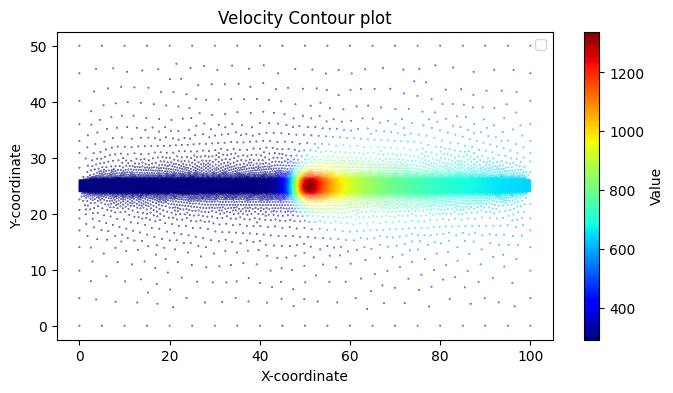

In [11]:
print(np.max(T))
plt.figure(figsize=(8,4))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=T, cmap='jet', s=.1, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

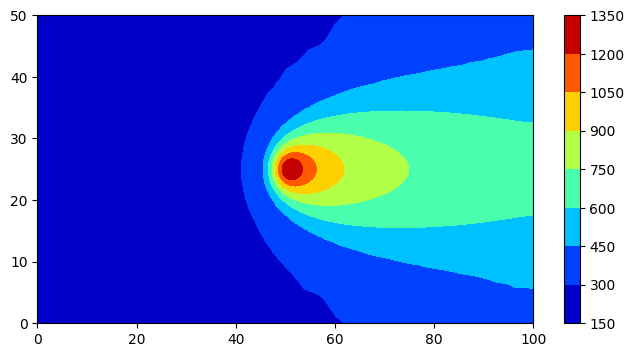

In [12]:
plt.figure(figsize=(8,4))
plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],T.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()

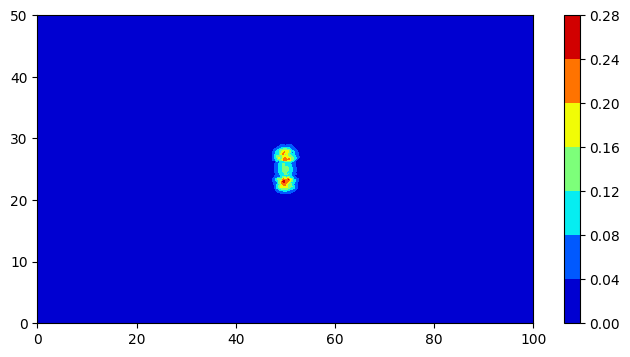

In [13]:
plt.figure(figsize=(8,4))
plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],mesh.S.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()

In [14]:
n = 0
for ele in mesh.triNodesTags:
    n += 1 if np.min(mesh.coords[ele-1,1]) >=24 and np.min(mesh.coords[ele-1,1]) <= 26 else 0
print('Value of H is '+str((100*2/n)**.5)+' in mm')

Value of H is 0.10926514984381615 in mm


In [ ]:
np.where(mesh.coords[:,1]>=24*mesh.coords[:,1]<=26)

In [16]:
len(mesh.triNodesTags)

28910

## Don't loook at the below code it's not updated with latest implementation

In [ ]:
dn = np.array([1,2,3]).reshape(-1,1)
(dn.T@dn)[0][0]

In [ ]:
mesh = RectangularMesh(mesh_factor=2,geo_file='rectangle.geo')

In [ ]:
A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
coords = mesh.coords
dirichiletBoundary = np.where(coords[:,0] == 0)[0]
n = S.shape[0]
nodes = np.arange(n)
dirichiletBoundaryTemperature = 20
Temperature = np.ones((n,1))*dirichiletBoundaryTemperature
interiorNodes = np.delete(nodes,dirichiletBoundary)

In [ ]:
((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
Temperature[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
np.sum(((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=Temperature, cmap='jet', s=7, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

In [ ]:
np.max(Temperature)

In [ ]:
nodesForAnalysis = np.where(abs(coords[:,1]-20) <= .5)[0]
plt.title('Velcity v/s X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Velocity')
plt.scatter(coords[nodesForAnalysis, 0], Temperature[nodesForAnalysis],s=3)
plt.legend()
plt.show()